### Time to get your hands dirty! Fun with Gamma Ray Bursts.

Let's look at the latest database of Gamma Ray Bursts.

 - The database can be downloaded at https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt
 - You can find the physical meaning of each variable at https://user-web.icecube.wisc.edu/~grbweb_public/Variables.html 


This edition of "get your hands dirty" is very open ended (we're getting closer and closer to real research...). You have a cool dataset, explore it! Play with the data, apply some of the tecniques we have seen in classes so far, etc. **Be creative! You're discovering**


Some relevant physical questions you might want to tackle include:

- Does the distribution contain different sub-populations? How many?
- What's the threshold between the classes?
- If you try two clustering methods, do you get more or less the same?
- How do methods respond to outliers?
- What variable(s) shows the multi-modality more evidently?
- Are all GRBs equally likely to be observed? 


In [1]:
import numpy as np
import pandas as pd
import requests
from matplotlib import pyplot as plt
from sklearn.cluster import KMeans
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV

# Download file
r = requests.get('https://user-web.icecube.wisc.edu/~grbweb_public/Summary_table.txt')
with open("Summary_table.txt", 'wb') as f:
    f.write(r.content)

# Read content with data cleaning
data = np.loadtxt("Summary_table.txt", dtype='str',unpack='True')

# Read headers
with open("Summary_table.txt",'r') as f:
    names= np.array([n.strip().replace(" ","_") for n in f.readlines()[1].replace("#","").replace("\n","").lstrip().split('    ') if n.strip()!=''])


In [3]:
names

array(['GRB_name', 'GRB_name_Fermi', 'T0', 'ra', 'decl', 'pos_error',
       'T90', 'T90_error', 'T90_start', 'fluence', 'fluence_error',
       'redshift', "'T100'", 'GBM_located', 'mjd_(T0)'], dtype='<U14')

In [2]:
T0 = np.array(data[2], dtype = str)
ra = np.array(data[3], dtype= float)
decl = np.array(data[4], dtype = float)
T90=np.array(data[6],dtype=float)
fluence = np.array(data[9], dtype = float)
redshift = np.array(data[11], dtype = float)
T100 = np.array(data[12], dtype = float)
condition = (T90 != -999) 
T90 = T90[condition]
log10T90 = np.log10(T90)

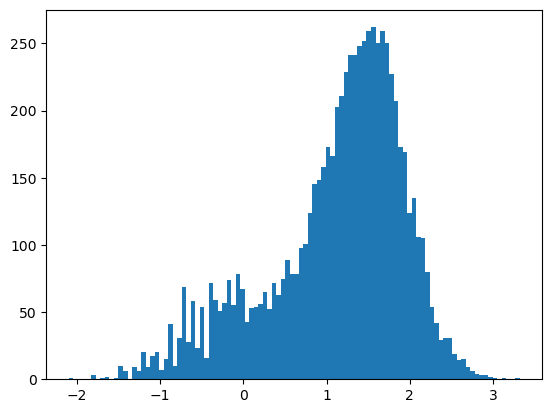

In [4]:
plt.hist(log10T90, bins = 100)
plt.show()

In [146]:
#Execute this cell to determine the bandwidth
bwrange = np.linspace(0.01,1.0, 40) # Test 30 bandwidths from 0.1 to 1.0
K = 2 # Do 5-fold cross validation
grid = GridSearchCV(KernelDensity(), {'bandwidth': bwrange}, cv= K) # Try each bandwidth with K-folds
grid.fit(log10T90[:, None]) #Fit the histogram data that we started the lecture with.
h_opt = grid.best_params_['bandwidth']
print(h_opt)

0.13692307692307693


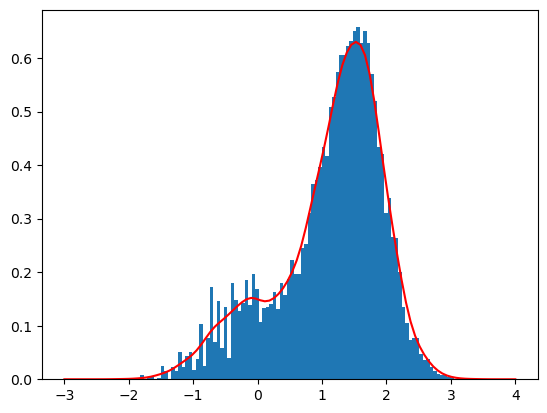

In [147]:
pdf = kde_sklearn(log10T90,bandwidth=h_opt)
plt.plot(xgrid,pdf,c='red')
plt.hist(log10T90, bins = 100, density = True);

In [149]:
clf = KMeans(n_clusters = 2)
clf.fit(log10T90[:, None])

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=2)

In [177]:
clf.cluster_centers_

array([[-0.04011202],
       [ 1.52285582]])

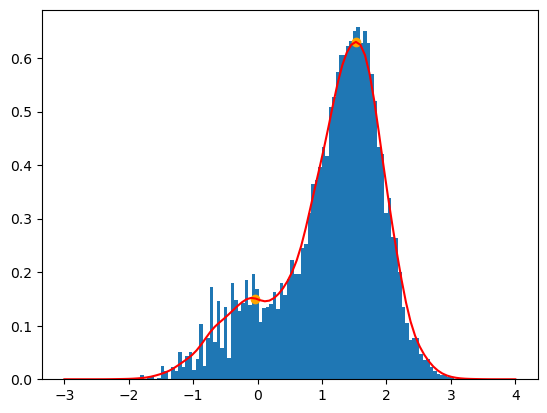

In [209]:
plt.plot(xgrid,pdf,c='red')
counts, edges, bars = plt.hist(log10T90, bins = 100, density = True)
plt.scatter(clf.cluster_centers_[0], pdf[np.argmin(np.abs(clf.cluster_centers_[0]-xgrid))], color = 'orange')
plt.scatter(clf.cluster_centers_[1], pdf[np.argmin(np.abs(clf.cluster_centers_[1]-xgrid))], color = 'orange');

C:\Users\hp\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


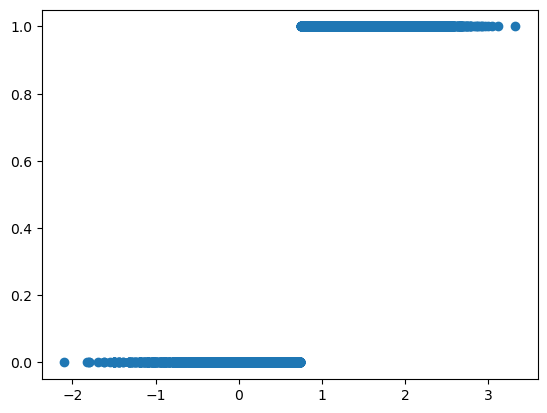

In [227]:
plt.scatter(log10T90, clf.fit_predict(log10T90[:, None]))

aggiungi confronto con gaussian mixture e calcolo edge